In [2]:
!pip install optuna

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.4kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.48MB/s]
[I 2025-04-19 17:41:28,718] A new study created in memory with name: no-name-d9ca527d-60ac-4bb9-b248-b6e43d4cddf1
[I 2025-04-19 17:43:00,786] Trial 0 finished with value: 0.9043 and parameters: {'lr': 9.050324622604288e-05, 'num_epoch': 20, 'n_pred_layers': 3, 'pred_hidden_0': 64, 'pred_hidden_1': 512, 'pred_hidden_2': 128, 'n_gate_layers': 2, 'gate_hidden_0': 32, 'gate_hidden_1': 64, 'pred_activation': 'ReLU', 'a': 0.5552371994717038, 'sigma': 0.0925030024042228, 'lam': 1.5741215293220904e-05}. Best is trial 0 with value: 0.9043.
[I 2025-04-19 17:47:33,039] Trial 1 finished with value: 0.8752 and parameters: {'lr': 0.021763865331344764, 'num_epoch': 50, 'n_pred_layers': 1, 'pred_hidden_0': 512, 'n_gate_layers': 1, 'gate_hidden_0': 64, 'pred_activation': 'Tanh', 'a': 0.673391676

Best trial:
FrozenTrial(number=34, state=1, values=[0.7845], datetime_start=datetime.datetime(2025, 4, 19, 18, 57, 7, 298881), datetime_complete=datetime.datetime(2025, 4, 19, 18, 58, 31, 472174), params={'lr': 0.00012657934747674088, 'num_epoch': 20, 'n_pred_layers': 1, 'pred_hidden_0': 128, 'n_gate_layers': 2, 'gate_hidden_0': 64, 'gate_hidden_1': 64, 'pred_activation': 'ReLU', 'a': 0.9316002423613783, 'sigma': 0.9939356050839585, 'lam': 0.005761872062336786}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'num_epoch': CategoricalDistribution(choices=(10, 20, 30, 50)), 'n_pred_layers': IntDistribution(high=3, log=False, low=1, step=1), 'pred_hidden_0': CategoricalDistribution(choices=(64, 128, 256, 512)), 'n_gate_layers': IntDistribution(high=2, log=False, low=1, step=1), 'gate_hidden_0': CategoricalDistribution(choices=(32, 64, 128)), 'gate_hidden_1': CategoricalDistribution(choices=(32, 64, 1

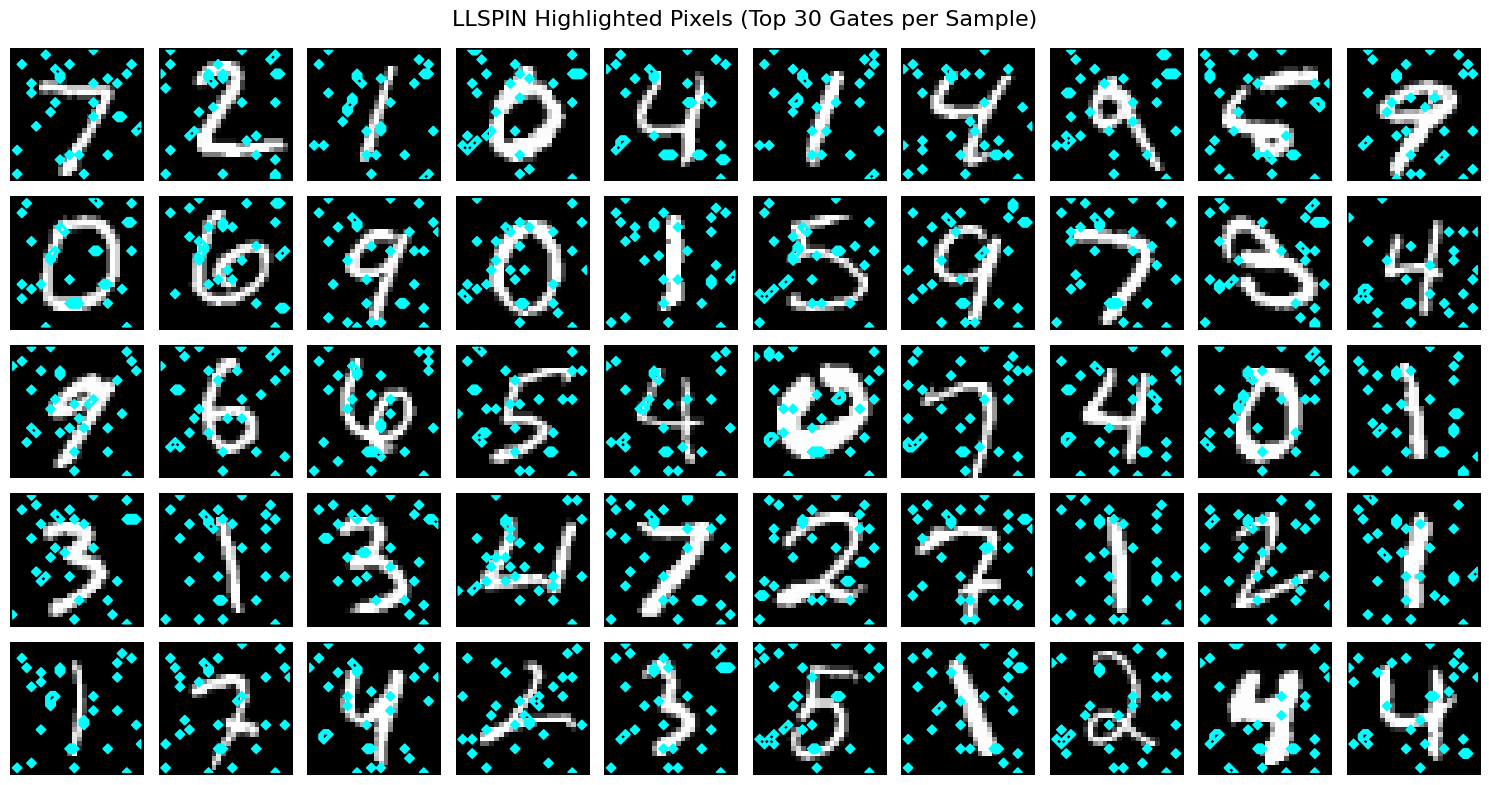

In [3]:
# llspin_mnist_optuna_optimized.py
# LLSPIN PyTorch implementation adapted for MNIST classification with Optuna hyperparameter tuning

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np
import optuna
import os
import random
from sklearn.metrics import accuracy_score

# -----------------------------
# 0. Set seed for reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----------------------
# 1. LLSPIN Components
# ----------------------
class HardSigmoid(nn.Module):
    def __init__(self, a):
        super().__init__()
        self.a = a
    def forward(self, x):
        return torch.clamp(self.a * x + 0.5, 0., 1.)

class GatingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, a, sigma):
        super().__init__()
        self.a = a
        self.sigma = sigma
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        self.hidden = nn.Sequential(*layers)
        self.alpha_layer = nn.Linear(last_dim, input_dim)
        self.hard_sigmoid = HardSigmoid(a)
    def forward(self, x, is_training=True):
        alpha = self.alpha_layer(self.hidden(x))
        if is_training:
            noise = torch.randn_like(alpha) * self.sigma
            z = alpha + noise
            gate = self.hard_sigmoid(z)
        else:
            gate = self.hard_sigmoid(alpha)
        return gate, alpha

class PredictionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim, activation_type='ReLU'):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            if activation_type == 'ReLU':
                layers.append(nn.ReLU())
            elif activation_type == 'Tanh':
                layers.append(nn.Tanh())
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

class LSPIN(nn.Module):
    def __init__(self, input_dim, pred_hidden, output_dim, gate_hidden, a, sigma, lam, feature_selection=True, pred_activation='ReLU'):
        super().__init__()
        self.feature_selection = feature_selection
        self.a = a
        self.sigma = sigma
        self.lam = lam
        if self.feature_selection:
            self.gating_net = GatingNetwork(input_dim, gate_hidden, a, sigma)
        self.pred_net = PredictionNetwork(input_dim, pred_hidden, output_dim, pred_activation)
        self.loss_fn = nn.CrossEntropyLoss()
    def forward(self, x, y=None, train_gates=True):
        if self.feature_selection:
            gates, alpha = self.gating_net(x, is_training=train_gates)
            x = x * gates
        else:
            alpha = None
        logits = self.pred_net(x)
        output = {'logits': logits, 'alpha': alpha}
        if y is not None:
            output['loss'] = self.loss_fn(logits, y)
        return output
    def get_prob_alpha(self, x):
        with torch.no_grad():
            _, alpha = self.gating_net(x, is_training=False)
            return self.gating_net.hard_sigmoid(alpha).cpu().numpy()

# -----------------------------
# 2. Load MNIST Data
# -----------------------------
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False)

# -----------------------------
# 3. Training Loop
# -----------------------------
def train_and_eval(trial, lr, num_epoch, pred_hidden, gate_hidden, a, sigma, lam, pred_activation):
    input_dim = 28 * 28
    model = LSPIN(
        input_dim=input_dim,
        pred_hidden=pred_hidden,
        output_dim=10,
        gate_hidden=gate_hidden,
        a=a,
        sigma=sigma,
        lam=lam,
        feature_selection=True,
        pred_activation=pred_activation
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=lam) # Incorporate weight decay

    # Convert all training data to tensors
    X_train = torch.cat([x for x, _ in train_loader], dim=0).to(torch.float32)
    Y_train = torch.cat([y for _, y in train_loader], dim=0).to(torch.long)

    for epoch in range(num_epoch):
        model.train()
        output = model(X_train, Y_train, train_gates=True)
        loss = output['loss']
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        X_test = torch.cat([x for x, _ in test_loader], dim=0).to(torch.float32)
        Y_test = torch.cat([y for _, y in test_loader], dim=0).to(torch.long)
        preds = model(X_test, train_gates=False)['logits'].argmax(dim=1).cpu().numpy()
        acc = accuracy_score(Y_test.cpu().numpy(), preds)
        return 1.0 - acc, model, X_train.cpu().numpy(), Y_train.cpu().numpy()

# -----------------------------
# 4. Optuna Objective
# -----------------------------
def optuna_objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_epoch = trial.suggest_categorical('num_epoch', [10, 20, 30, 50])

    # Tune prediction network hidden layers
    n_pred_layers = trial.suggest_int('n_pred_layers', 1, 3)
    pred_hidden = []
    for i in range(n_pred_layers):
        pred_hidden.append(trial.suggest_categorical(f'pred_hidden_{i}', [64, 128, 256, 512]))

    # Tune gating network hidden layers
    n_gate_layers = trial.suggest_int('n_gate_layers', 1, 2)
    gate_hidden = []
    for i in range(n_gate_layers):
        gate_hidden.append(trial.suggest_categorical(f'gate_hidden_{i}', [32, 64, 128]))

    # Tune activation function for prediction network
    pred_activation = trial.suggest_categorical('pred_activation', ['ReLU', 'Tanh'])

    # Tune hard sigmoid slope
    a = trial.suggest_float('a', 0.5, 2.0)

    # Tune noise standard deviation
    sigma = trial.suggest_float('sigma', 0.01, 1.0, log=True)

    # Tune regularization strength (weight decay)
    lam = trial.suggest_float('lam', 1e-5, 1e-2, log=True)

    val_loss, _, _, _ = train_and_eval(trial, lr, num_epoch, pred_hidden, gate_hidden, a, sigma, lam, pred_activation)
    return val_loss

# -----------------------------
# 5. Run and Plot
# -----------------------------
def run_study():
    study = optuna.create_study(direction="minimize")
    study.optimize(optuna_objective, n_trials=100) # Increase n_trials for better tuning

    print("Best trial:")
    print(study.best_trial)

    # Retrain best model for plots
    best_params = study.best_trial.params
    _, model, X_train, Y_train = train_and_eval(None, best_params['lr'], best_params['num_epoch'],
                                                [best_params[f'pred_hidden_{i}'] for i in range(best_params['n_pred_layers'])],
                                                [best_params[f'gate_hidden_{i}'] for i in range(best_params['n_gate_layers'])],
                                                best_params['a'], best_params['sigma'], best_params['lam'],
                                                best_params['pred_activation'])

    gate_matrix = model.get_prob_alpha(torch.tensor(X_train, dtype=torch.float32))

    # Visualization similar to the paper
    fig, axes = plt.subplots(5, 10, figsize=(15, 8))
    sample_images = torch.cat([x for x, _ in test_loader], dim=0).view(-1, 28, 28)
    gate_matrix = model.get_prob_alpha(torch.cat([x for x, _ in test_loader], dim=0))
    topk = 30  # number of most relevant pixels

    for i in range(5):
        for j in range(10):
            idx = i * 10 + j
            img = sample_images[idx].numpy()
            gate = gate_matrix[idx]
            gate_mask = np.zeros_like(gate)
            gate_mask[np.argsort(gate)[-topk:]] = 1
            gate_mask = gate_mask.reshape(28, 28)

            ax = axes[i, j]
            ax.imshow(img, cmap='gray')
            ax.contour(gate_mask, colors='cyan', linewidths=1)
            ax.axis('off')

    plt.suptitle("LLSPIN Highlighted Pixels (Top 30 Gates per Sample)", fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_study()

Retraining the model...
Epoch 30/30, Loss: 2.3038
Training complete.

Standard MNIST Evaluation:
Accuracy on the test set: 0.0590
AUC (One-vs-Rest): 0.4986
RMSE: 0.3000


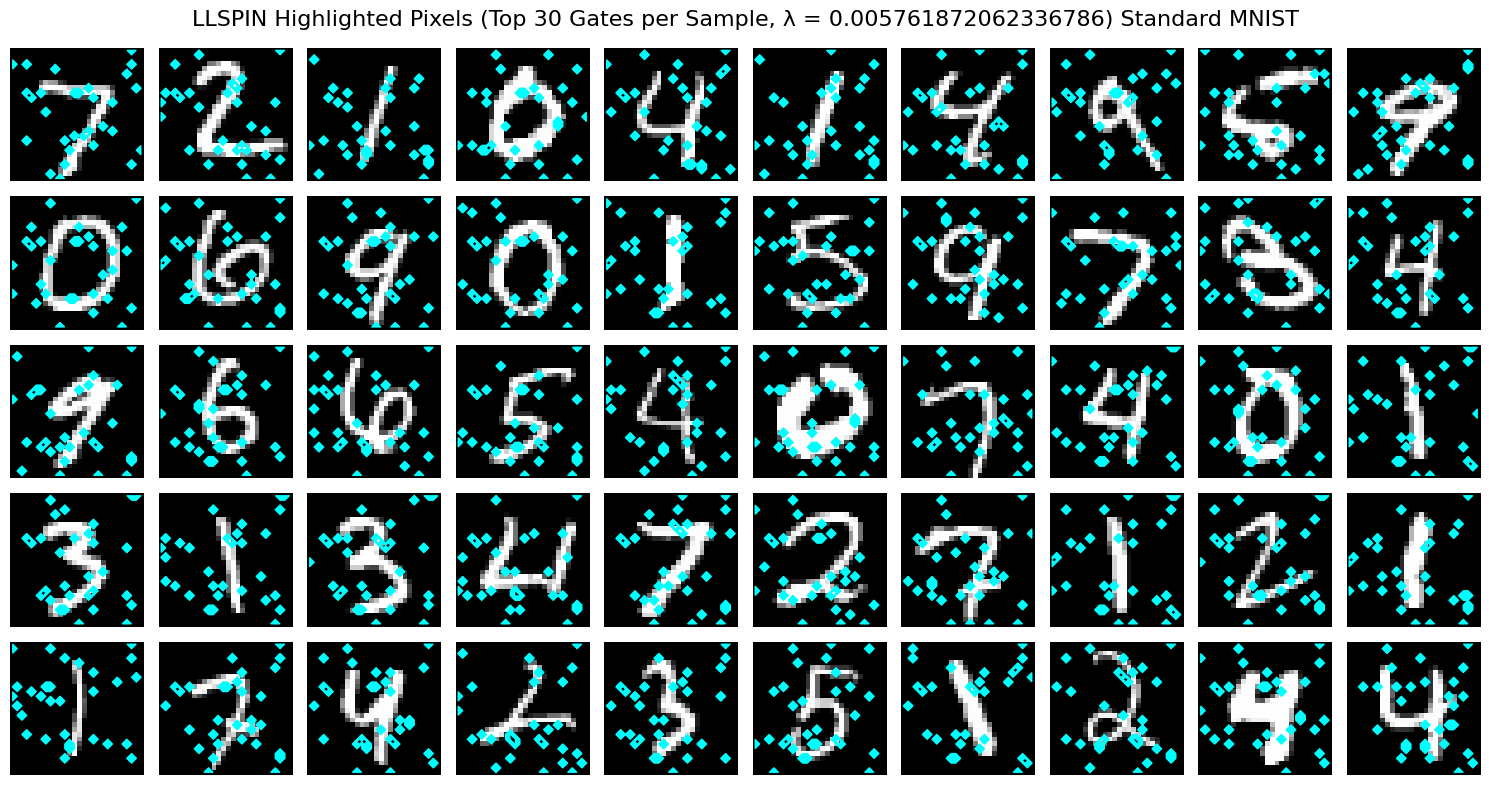

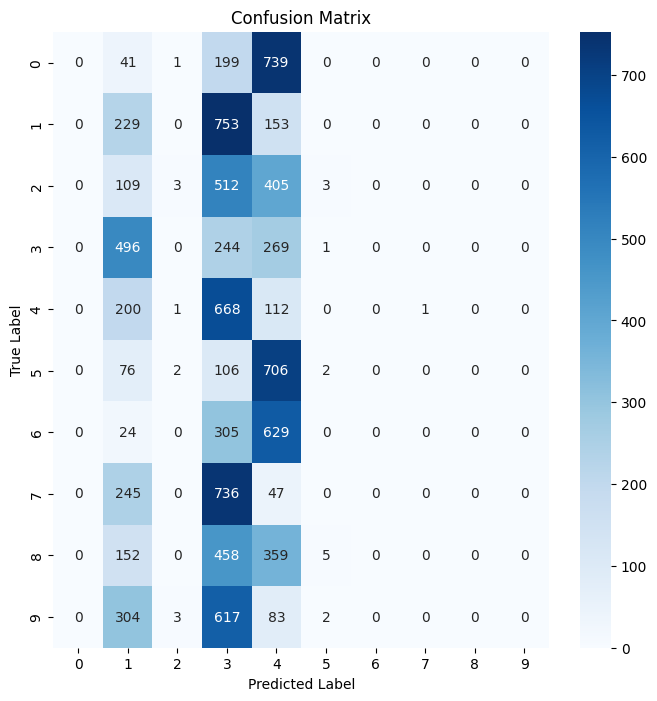

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, confusion_matrix
import seaborn as sns
import os
import random

# -----------------------------
# 0. Set seed for reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----------------------
# 1. LLSPIN Components (Same as before)
# ----------------------
class HardSigmoid(nn.Module):
    def __init__(self, a):
        super().__init__()
        self.a = a

    def forward(self, x):
        return torch.clamp(self.a * x + 0.5, 0., 1.)

class GatingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, a, sigma):
        super().__init__()
        self.a = a
        self.sigma = sigma
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        self.hidden = nn.Sequential(*layers)
        self.alpha_layer = nn.Linear(last_dim, input_dim)
        self.hard_sigmoid = HardSigmoid(a)

    def forward(self, x, is_training=True):
        alpha = self.alpha_layer(self.hidden(x))
        if is_training:
            noise = torch.randn_like(alpha) * self.sigma
            z = alpha + noise
            gate = self.hard_sigmoid(z)
        else:
            gate = self.hard_sigmoid(alpha)
        return gate, alpha

class PredictionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim, activation_type='ReLU'):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            if activation_type == 'ReLU':
                layers.append(nn.ReLU())
            elif activation_type == 'Tanh':
                layers.append(nn.Tanh())
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class LSPIN(nn.Module):
    def __init__(self, input_dim, pred_hidden, output_dim, gate_hidden, a, sigma, lam, feature_selection=True, pred_activation='ReLU'):
        super().__init__()
        self.feature_selection = feature_selection
        self.a = a
        self.sigma = sigma
        self.lam = lam
        if self.feature_selection:
            self.gating_net = GatingNetwork(input_dim, gate_hidden, a, sigma)
        self.pred_net = PredictionNetwork(input_dim, pred_hidden, output_dim, pred_activation)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, y=None, train_gates=True):
        if self.feature_selection:
            gates, alpha = self.gating_net(x, is_training=train_gates)
            x = x * gates
        else:
            alpha = None
        logits = self.pred_net(x)
        output = {'logits': logits, 'alpha': alpha}
        if y is not None:
            output['loss'] = self.loss_fn(logits, y)
        return output

    def get_prob_alpha(self, x):
        with torch.no_grad():
            _, alpha = self.gating_net(x, is_training=False)
            return self.gating_net.hard_sigmoid(alpha).cpu().numpy()

# -----------------------------
# 2. Load MNIST Data
# -----------------------------
def load_mnist(train_size=60000):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    full_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if train_size < 60000:
        train_set, _ = torch.utils.data.random_split(full_train_set, [train_size, 60000 - train_size])
    else:
        train_set = full_train_set

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False)

    return train_loader, test_loader

# -----------------------------
# 3. Evaluate with Given Hyperparameters
# -----------------------------
def evaluate_llspin(params, train_loader, test_loader, num_epoch=30):
    input_dim = 28 * 28
    model = LSPIN(
        input_dim=input_dim,
        pred_hidden=[params[f'pred_hidden_{i}'] for i in range(params['n_pred_layers'])],
        output_dim=10,
        gate_hidden=[params[f'gate_hidden_{i}'] for i in range(params['n_gate_layers'])],
        a=params['a'],
        sigma=params['sigma'],
        lam=params['lam'],
        feature_selection=True,
        pred_activation=params['pred_activation']
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], weight_decay=params['lam'])

    # Train on the entire training set
    X_train = torch.cat([x for x, _ in train_loader], dim=0).to(torch.float32)
    Y_train = torch.cat([y for _, y in train_loader], dim=0).to(torch.long)

    print("Retraining the model...")
    for epoch in range(num_epoch):
        model.train()
        output = model(X_train, Y_train, train_gates=True)
        loss = output['loss']
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}/{num_epoch}, Loss: {loss.item():.4f}", end='\r')
    print("\nTraining complete.")

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        X_test = torch.cat([x for x, _ in test_loader], dim=0).to(torch.float32)
        Y_test = torch.cat([y for _, y in test_loader], dim=0).to(torch.long)
        logits = model(X_test, train_gates=False)['logits']
        probs = F.softmax(logits, dim=1).cpu().numpy()  # Get probabilities
        preds = logits.argmax(dim=1).cpu().numpy()
        targets = Y_test.cpu().numpy()

        accuracy = accuracy_score(targets, preds)

        # AUC (One-vs-Rest)
        try:
            auc = roc_auc_score(targets, probs, multi_class='ovr')
        except ValueError:
            auc = 0.0  # Handle cases with only one class in the test set

        # RMSE (Not recommended for classification, but included)
        # Convert class probabilities to a numerical representation (one-hot encoded)
        one_hot_targets = np.eye(10)[targets]
        rmse = np.sqrt(mean_squared_error(one_hot_targets, probs))

        conf_mat = confusion_matrix(targets, preds)

    # Get selected features (average gates over the test set)
    gate_matrix_test = model.get_prob_alpha(X_test)

    return accuracy, auc, rmse, conf_mat, model, gate_matrix_test, X_test, Y_test

# -----------------------------
# 4. Visualization Functions (Same as before)
# -----------------------------
def visualize_active_gates(model, test_loader, lam_value, title_suffix=""):
    model.eval()
    sample_images = torch.cat([x for x, _ in test_loader], dim=0).view(-1, 28, 28)
    gate_matrix = model.get_prob_alpha(torch.cat([x for x, _ in test_loader], dim=0))
    topk = 30  # Number of most relevant pixels

    fig, axes = plt.subplots(5, 10, figsize=(15, 8))

    for i in range(5):
        for j in range(10):
            idx = i * 10 + j
            img = sample_images[idx].numpy()
            gate = gate_matrix[idx]
            gate_mask = np.zeros_like(gate)
            gate_mask[np.argsort(gate)[-topk:]] = 1
            gate_mask = gate_mask.reshape(28, 28)

            ax = axes[i, j]
            ax.imshow(img, cmap='gray')
            ax.contour(gate_mask, colors='cyan', linewidths=1)
            ax.axis('off')

    plt.suptitle(f"LLSPIN Highlighted Pixels (Top {topk} Gates per Sample, λ = {lam_value}) {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5. Main Execution
# -----------------------------
if __name__ == "__main__":
    # Best parameters from previous Optuna run (replace with your actual best params)
    best_params = {
        'lr': 0.00012657934747674088,
        'num_epoch': 20,
        'n_pred_layers': 1,
        'pred_hidden_0': 128,
        'n_gate_layers': 2,
        'gate_hidden_0': 64,
        'gate_hidden_1': 64,
        'pred_activation': 'ReLU',
        'a': 0.9316002423613783,
        'sigma': 0.9939356050839585,
        'lam': 0.005761872062336786
    }

    # 1. Standard Evaluation
    train_loader, test_loader = load_mnist()
    accuracy, auc, rmse, confusion_matrix_result, best_trained_model, gate_matrix_test, X_test, Y_test = evaluate_llspin(best_params, train_loader, test_loader, num_epoch=30)

    print(f"\nStandard MNIST Evaluation:")
    print(f"Accuracy on the test set: {accuracy:.4f}")
    print(f"AUC (One-vs-Rest): {auc:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # 2. Visualize Active Gates (Similar to paper's figures)
    visualize_active_gates(best_trained_model, test_loader, lam_value=best_params['lam'], title_suffix="Standard MNIST")

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # You can add further analysis or visualization as needed